<div class="alert alert-block alert-danger">
<h1>Adult income dataset</h1>
</div>

https://www.kaggle.com/wenruliu/adult-income-dataset

An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.<br>

Fields<br>
The dataset contains 16 columns<br>
Target filed: Income<br>
-- The income is divide into two classes: <=50K and >50K <br>
Number of attributes: 14<br>
-- These are the demographics and other features to describe a person<br>

We can explore the possibility in predicting income level based on the individual’s personal information.<br>

This dataset comes from the UCI(http://archive.ics.uci.edu/ml/index.php) repository of machine learning databases. More details are available in the original UCI documentation (https://www.cs.toronto.edu/~delve/data/adult/adultDetail.html)

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Import Libraries and Read Dataset](#1.0)<br>
[Functions To Be Used](#2.0)<br>
[Initialize Spark and Load Data](#3.0)<br>
[Exploratory Data Analysis (EDA)](#4.0)<br>
    <ul>
        <li>[Analyze each feature](#4.1)</li>
    </ul>
[Machine Learning Algorithms and Results](#5.0)<br>
    <ul>
        <li>[String Indexer](#5.1)</li>
        <li>[Vector Assembler](#5.2)</li>
        <li>[Feature engineering](#5.3)</li>
        <li>[Correlation of the features](#5.4)</li>
        <li>[Over-sampling using SMOTE](#5.5)</li>
        <li>[Normalization](#5.4)</li>
        <li>[Building ML models](#5.5)</li>
            <ul>
                <li>Logistic Regression</li>
                <li>Decision Tree Classification</li>
                <li>Random Forest Classification]</li>
                <li>Naive Bayes Classification</li>
                <li>Gradient-Boosted Tree Classification</li>
                <li>Linear Support Vector Machine</li>
            </ul>
        <li>[Model selection - final](#5.6)</li>
        <li>[Evaluation of the selected model](#3.7)</li>
            <ul>
                <li>ROC/AUC</li>
                <li>TPR/TNR - Threshold</li>
                <li>Precision(PPV)/NPV - Recall</li>
                <li>Accuracy - Threshold</li>
            </ul>
    </ul>

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Functions to be used</h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pyspark
    </h4>
</div>

In [2]:
def count_null_columns(df):
    null_counts = df.select([count(when((col(c).isNull()), c)).alias(c) for c in df.columns])\
    .collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v == 0]
    df = df.drop(*to_drop)
    if len(df.columns) > 0:
        df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    else:
        print("There are no null values in the dataframe.")
        
    return df

In [3]:
from pyspark.sql.functions import sum, round

def percentCol(df, col):
    df = df.groupBy(col).count().orderBy("count", ascending=False)
    if df.count() > 10:
        df = df.limit(8)
        print("The first 8 items have been plotted.")
    df = df.withColumn('percentage (%)', 100*df['count'] / df.agg(sum("count")).collect()[0][0])
    df = df.select("*",round("percentage (%)", 2).alias('percentage (%)_')).drop('percentage (%)')
    df = df.withColumnRenamed('percentage (%)_', 'percentage (%)')
    df = df.na.fill('nan')
    df = df.toPandas().set_index(df.columns[0])
    return df

In [4]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

def stringIndexer(df, inputCols, dropInput=False):
    outputCols = [f"{i}_si" for i in inputCols]

    for i in range(len(inputCols)):
        inputCol = inputCols[i]
        outputCol = outputCols[i]
        indexer = StringIndexer(inputCol=inputCol, outputCol=outputCol, handleInvalid="keep").fit(df)
        df = indexer.transform(df)\
           .withColumn(outputCol, when(col(outputCol) == len(indexer.labels), None).otherwise(col(outputCol)))
        if dropInput:
            df = df.drop(inputCol).withColumnRenamed(outputCol, inputCol)
        df = df.withColumn(inputCol, df[inputCol].cast(IntegerType()))
        
    return df

In [5]:
from pyspark.ml.feature import OneHotEncoder

def oneHotEncoder(df, inputCols, stringIndexer=False):
    if stringIndexer:
        for i in range(len(inputCols)):
            inputCol = inputCols[i]
            outputCol = f"{inputCol}_si"
            indexer = StringIndexer(inputCol=inputCol, outputCol=outputCol).fit(df)
            data = indexer.transform(df).withColumn(outputCol, 
                                                    when(col(outputCol) == len(indexer.labels), None)
                                                    .otherwise(col(outputCol))).drop(inputCol)
            ohe = OneHotEncoder(inputCol=outputCol, outputCol=f"{inputCol}_ohe").fit(data)
            data = ohe.transform(data).drop(outputCol)
        return data
    else:
        for i in range(len(inputCols)):
            inputCol = inputCols[i]
            ohe = OneHotEncoder(inputCol=inputCol, outputCol=f"{inputCol}_ohe").fit(df)
            df = ohe.transform(df).drop(inputCol)
        return df

In [6]:
from pyspark.ml.feature import VectorAssembler

def vectorAssembler(df, inputCols, dependentCol):
    va = VectorAssembler(inputCols=inputCols, outputCol='features')
    output = va.transform(df)
    df_final = output.select('features', dependentCol)
    
    return df_final

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
import math

def BuildMLModel(model, df_train, df_test, paramGrid, threshold=0.5, modelName=None):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                  metricName="accuracy")
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cv_trained = cv.fit(df_train)
    cv_pred = cv_trained.transform(df_test)

    if modelName=="LinearSVC":
        y_prob = np.array([(np.exp(np.array([i[0][0], -i[0][0]]))
                                  /(1+np.exp(np.array([i[0][0], -i[0][0]]))))[1] for i in cv_pred
                                 .select("rawPrediction").collect()])
        y = np.array([i[0] for i in cv_pred.select("label").collect()])
    else:
        y_prob = np.array([i[0][1] for i in cv_pred.select("probability").collect()])
        y = np.array([i[0] for i in cv_pred.select("label").collect()])
    y_pred = (y_prob  >= threshold).astype('int')

    model_cm = confusion_matrix(y, y_pred)
    model_cm_norm = confusion_matrix(y, y_pred, normalize='true')

    model_cm_metrics = confusion_matrix_func(model_cm, model_cm_norm)
    
    return model_cm_metrics, cv_pred

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [9]:
from pyspark.sql.functions import col

# plot a stacked bar chart to show how a feature is categorized using the another feature
def stacked_bar_chart(df_target, target_col, figsize=(8,5)):
    
    df = df_target.groupBy(target_col, "label").count().orderBy("count", ascending=False)\
    .groupBy(target_col).pivot("label").sum("count").orderBy([target_col], ascending=True).fillna(0)\
    .withColumn('sum_each', col("0") + col("1")).orderBy("sum_each", ascending=False)\
    .select([target_col] + ["0", "1"]).toPandas().set_index(target_col)
    
    if len(df) > 10:
        df = df.iloc[:8, :]
        print("The first 8 items have been plotted.")
    
    print(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35
    
    colors = []
    for column in df.columns:
        if column == '0':
            colors.append('royalblue')
        elif column == '1':
            colors.append('mediumvioletred')
    
    x = [str(i) for i in df.index]
    y = 0
    for i, col_group in enumerate(df.columns):
        try:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors[i], label=df.columns[i])
        except:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors(i), label=df.columns[i])
        y += df[col_group].values
    
    ax.set_xticklabels(x, rotation = 45)
    
    ax.set_xlabel(df.index.name)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(axis='y', zorder=0, lw=0.2)
        
    plt.show()

In [10]:
def histogram(df, target_col, figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

    age_vals = [i[0] for i in df.select(target_col).na.drop().collect()]

    sigma = df.agg({target_col:'std'}).collect()[0][0]
    mean = df.agg({target_col:'mean'}).collect()[0][0]
    median = np.median(age_vals)
    mode = stats.mode(age_vals)[0][0]   

    x = mean + sigma * np.random.randn(1000)

    # fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    n, bins, patches = ax.hist(age_vals, 20, density=True, color='lightgreen', 
                                           stacked=True, alpha=0.75)

    # add mean, median and mode lines
    ax.axvline(mean, 0, 1, color='red', label='mean: {:.2f}'.format(mean))
    ax.axvline(median, 0, 1, color='blue', label='median: {:.2f}'.format(median))
    ax.axvline(mode, 0, 1, color='green', label='mode: {:.2f}'.format(mode))

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--', color ='black')

    ax.grid(True)
    ax.set_ylabel('Probability')
    ax.set_title(f'{target_col} (sigma={roundF(sigma, 2)})')
    ax.legend()
    fig.tight_layout()
    fig.show()

In [11]:
def create_heatmap(hm, cols, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    
    
    ax.set_xticks(np.arange(len(cols)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(cols)+1)-.5, minor=True)
    
    
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            hm_val = roundF(hm[i][j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

In [12]:
def autopct(pct_max, pct, allvals):
    if pct<pct_max:
        return ""
    else:
        # ATTENSION: roundF and sumF is used because of the Pyspark
        absolute = int(roundF(pct/100.*sumF(allvals), 0))
        return "{p:.1f}% \n({val})".format(p=pct, val=absolute)

def pie_chart(df, explode=None, title=None, pct_max=5, legend_pos=(0.8, 0, 0.4, 1), 
              p_theta_max=15, p_theta_min=2):
#     df = df.toPandas().set_index(df.columns[0])
#     df.index.name = None
    items = df.index
    values = df.iloc[:, 0]
    percent = df.iloc[:, 1]
    
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    #################################################################
    textprops = dict(horizontalalignment="center", verticalalignment="center", rotation=0, 
                     rotation_mode="anchor", size=12, weight= "bold", color="white")
    wedgeprops=dict(edgecolor="black", linewidth=1)
    labels = [f"{i} ({j} - {k:1.1f}%)" for i,j,k in zip(items, values, percent)]
    #################################################################
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: autopct(pct_max, pct, values), 
                                      textprops=textprops, radius=1, startangle=0, counterclock=True, 
                                      pctdistance = 0.6, wedgeprops=wedgeprops, explode=explode)
    #################################################################
    #---------------------------------------------------------------#
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center", ha="center")

    values_2 = [f"{i:1.1f}% ({j})" for i,j in zip(percent, values)]

    for i, p in enumerate(wedges):
        if (p.theta2 - p.theta1 < p_theta_max) & (p.theta2 - p.theta1 > p_theta_min):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.annotate(values_2[i], xy=(x, y), xytext=(1.6*np.sign(x), 1.5*y),
                        horizontalalignment=horizontalalignment, **kw)
    #---------------------------------------------------------------#
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size=16, weight="bold")

    plt.legend(labels=labels, fontsize=12, bbox_to_anchor=legend_pos)
        
    plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [13]:
def TP_FP_TN_FN_func(cm, dataframe):
    
    TN, FP, FN, TP = cm.ravel()

    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = roundF(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = roundF(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = roundF((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = roundF((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = roundF(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = roundF(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = roundF(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = roundF(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = roundF((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = roundF(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = roundF(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = roundF(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = roundF(FN / (FN + TP), 2)
    

    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 'Precision', 
                  'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    df_cm_metrics = pd.DataFrame([[TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR]], 
                                 columns=metrics_cols, index=[""])
    
    return df_cm_metrics

def confusion_matrix_func(cm, cm_norm, threshold=0.5):
    cm = cm.astype(int)

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    im_norm = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Reds', aspect='auto')
    
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    axes[1].set_xticks(np.arange(len(cm_norm.tolist())))
    axes[1].set_yticks(np.arange(len(cm_norm.tolist())))

    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
            
    for i in range(len(cm_norm.tolist())):
        for j in range(len(cm_norm.tolist())):
            text = axes[1].text(j, i, f"{roundF(cm_norm.tolist()[i][j]*100, 1)} %",
                           ha="center", va="center", size=16,
                           color="white" if cm_norm[i, j] > 0.5 else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Predicted value', size=16)
    axes[0].set_ylabel('Actual value', size=16)
    axes[0].set_title("Confusion matrix", fontsize=16, color="blue")

    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Predicted value', size=16)
    axes[1].set_ylabel('Actual value', size=16)
    axes[1].set_title("Normalized confusion matrix", fontsize=16, color="blue")
    
    fig.tight_layout()
    fig.show()
    
#     get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Test')
    
    return df_cm_metrics

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Import Libraries</h2>
</div>

<div class="alert alert-block alert-warning">
        Import libraries
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math, operator
from scipy import stats
import numpy as np 
import pandas as pd
# display all of the columns
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
%matplotlib inline

import findspark
findspark.init("/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2") 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

# for round, sum method
import pyspark.sql.functions as F
import builtins
roundF = getattr(builtins, "round")
sumF = getattr(builtins, "sum")
absF = getattr(builtins, "abs")

<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Initialize Spark and Load Data</h2>
</div>

<div class="alert alert-block alert-warning">
        Initialize Spark
</div>

In [14]:
spark=SparkSession.builder.appName('Dataframe').getOrCreate()
# spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/22 00:15:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/22 00:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<div class="alert alert-block alert-warning">
        Load the data
</div>

In [15]:
# read the dataset
df = spark.read.option('header','true').csv('../all_dfs/adult.csv', inferSchema=True)
pd.DataFrame(df.take(5), columns=df.columns)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [16]:
f"Total transactions: {df.count()}"

'Total transactions: 48842'

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Exploratory Data Analysis (EDA)</h2>
</div>

<a id='3.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Check missing values
</div>

In [17]:
count_null_columns(df)

There are no null values in the dataframe.


DataFrame[]

<div class="alert alert-block alert-success">
    <h4>
        income
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Distribution of total transactions
</div>

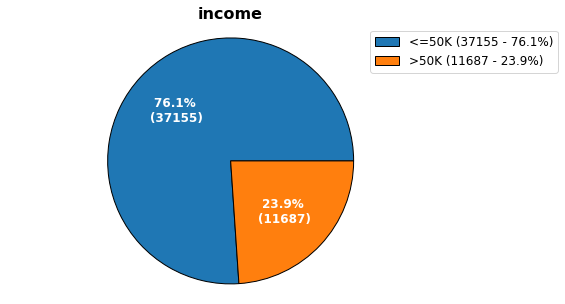

In [18]:
df_income = percentCol(df, 'income')
pie_chart(df_income, title='income')

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

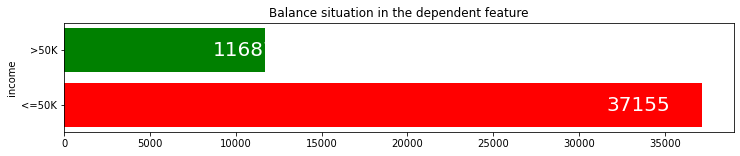

In [19]:
# The difference between >50K and <=50K values in the dependent feature is not same. 
# So the dataset is in imbalance.
uniqs = [i for i in df_income.index]
vals = [i for i in df_income["count"].values]

fig, ax = plt.subplots(figsize = (12, 2))
# Horizontal bar chart
ax.barh(uniqs, vals, align='center', color=['red', 'green'])
ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
ax.text(vals[1]-vals[1]*0.1, 1, vals[1], ha='center', va='center', color='w', size=20)
ax.set_ylabel("income")
ax.set_title('Balance situation in the dependent feature')

plt.show()

<div class="alert alert-block alert-warning">
        Change the names of unique values and remane the feature name as "label"
</div>

In [20]:
df = df.withColumn('label', when(df["income"]=='<=50K', 0).otherwise(1)).drop("income")

In [21]:
df.show(5)

+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+-----+
|age|workclass|fnlwgt|   education|educational-num|    marital-status|       occupation|relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|label|
+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+-----+
| 25|  Private|226802|        11th|              7|     Never-married|Machine-op-inspct|   Own-child|Black|  Male|           0|           0|            40| United-States|    0|
| 38|  Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male|           0|           0|            50| United-States|    0|
| 28|Local-gov|336951|  Assoc-acdm|             12|Married-civ-spouse|  Protective-serv|     Husband|White|  Male| 

<div class="alert alert-block alert-success">
    <h4>
        age
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Distribution of transactions performed at each step by type
</div>

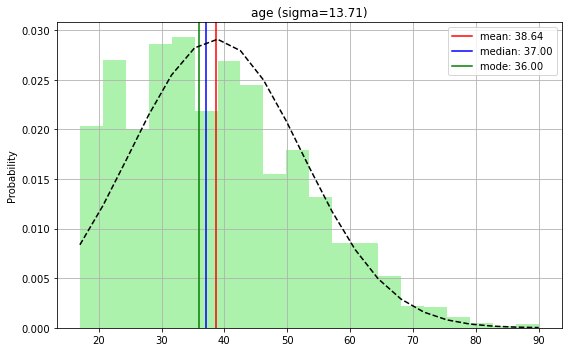

In [22]:
histogram(df, "age")

In [23]:
age_min = df.agg({"age": "min"}).collect()[0][0]
age_max = df.agg({"age": "max"}).collect()[0][0]
print(f"min. age: {age_min}, \nmax. age: {age_max}")

min. age: 17, 
max. age: 90


In [24]:
# Categorize the 'Customer_Age' column with the labels and bins and create a new column in the df dataframe
from pyspark.ml.feature import Bucketizer

bins = [age_min-1,21,31,41,51,61,71, age_max+1]
bucketizer = Bucketizer(splits=bins, inputCol="age", outputCol="AgeGrb")
df = bucketizer.setHandleInvalid("keep").transform(df)

In [25]:
labels = {None:None, 0.0:"0-20", 1.0: "21-30", 2.0:"31-40", 3.0: "41-50", 4.0: "51-60", 5.0: "61-70", 
          6.0: "71+"}
udf_foo = udf(lambda x: labels[x], StringType())
df = df.withColumn("AgeGrb", udf_foo("AgeGrb")).drop("age")

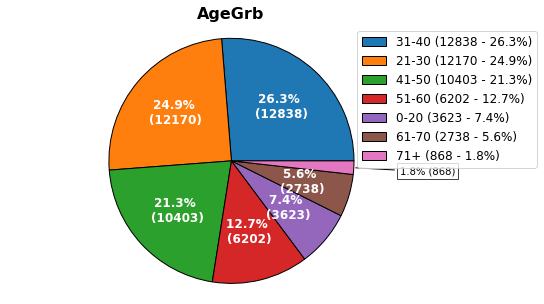

In [26]:
df_ageGrb = percentCol(df.na.fill('nan', subset=["AgeGrb"]), 'AgeGrb')
pie_chart(df_ageGrb, title='AgeGrb')

<div class="alert alert-block alert-success">
    <h4>
        workclass
    </h4>
</div>

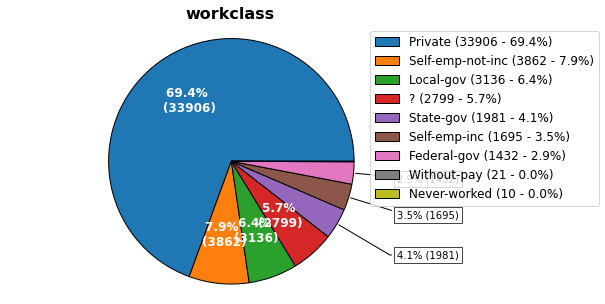

In [27]:
df_workclass = percentCol(df, 'workclass')
pie_chart(df_workclass, title='workclass')

                      0     1
workclass                    
Private           26519  7387
Self-emp-not-inc   2785  1077
Local-gov          2209   927
?                  2534   265
State-gov          1451   530
Self-emp-inc        757   938
Federal-gov         871   561
Without-pay          19     2
Never-worked         10     0


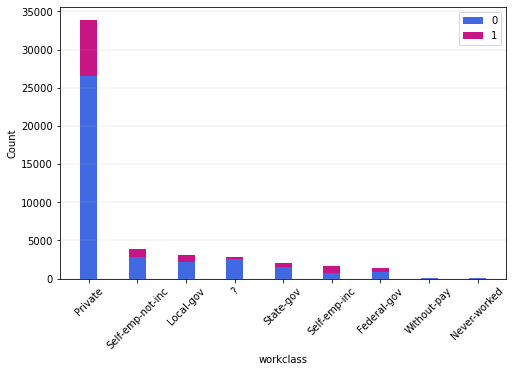

In [28]:
stacked_bar_chart(df, 'workclass')

<div class="alert alert-block alert-success">
    <h4>
        education
    </h4>
</div>

The first 8 items have been plotted.


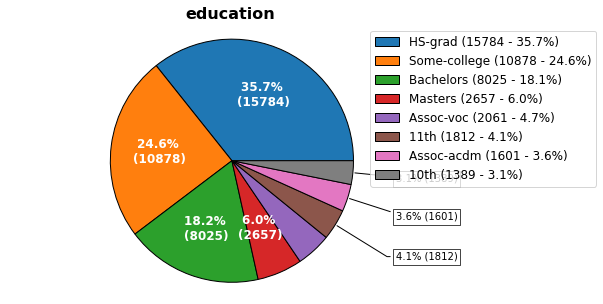

In [29]:
df_education = percentCol(df, 'education')
pie_chart(df_education, title='education')

The first 8 items have been plotted.
                  0     1
education                
HS-grad       13281  2503
Some-college   8815  2063
Bachelors      4712  3313
Masters        1198  1459
Assoc-voc      1539   522
11th           1720    92
Assoc-acdm     1188   413
10th           1302    87


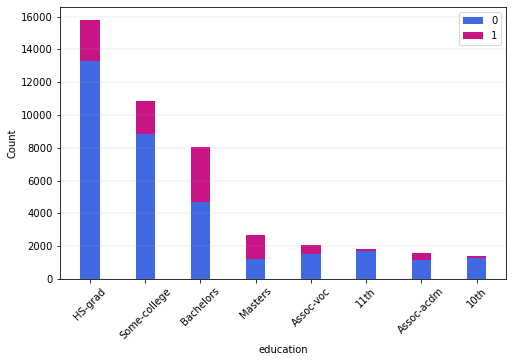

In [30]:
stacked_bar_chart(df, 'education')

<div class="alert alert-block alert-success">
    <h4>
        educational-num
    </h4>
</div>

The first 8 items have been plotted.


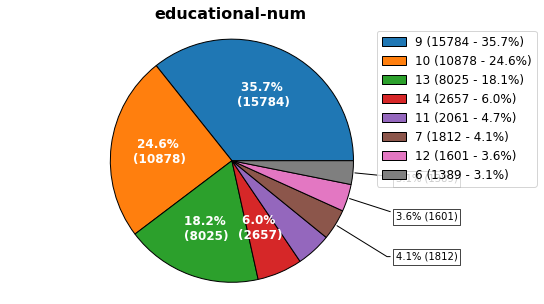

In [31]:
df_edu_num = percentCol(df, 'educational-num')
pie_chart(df_edu_num, title='educational-num')

The first 8 items have been plotted.
                     0     1
educational-num             
9                13281  2503
10                8815  2063
13                4712  3313
14                1198  1459
11                1539   522
7                 1720    92
12                1188   413
6                 1302    87


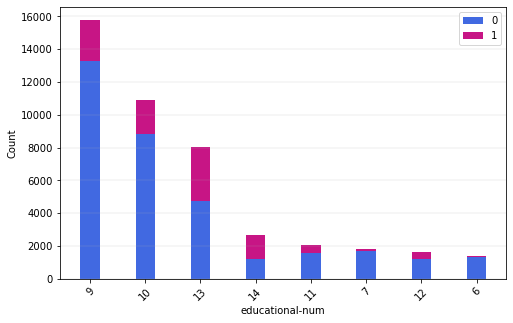

In [32]:
stacked_bar_chart(df, 'educational-num')

<div class="alert alert-block alert-success">
    <h4>
        marital-status
    </h4>
</div>

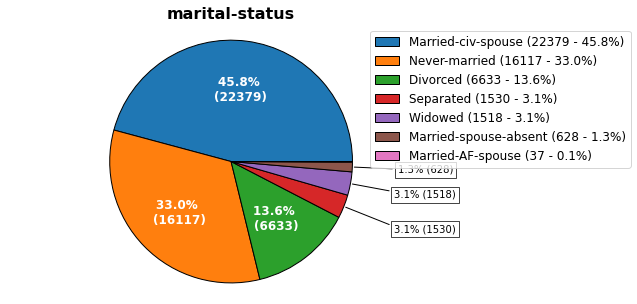

In [33]:
df_mar_st = percentCol(df, 'marital-status')
pie_chart(df_mar_st, title='marital-status')

                           0     1
marital-status                    
Married-civ-spouse     12395  9984
Never-married          15384   733
Divorced                5962   671
Separated               1431    99
Widowed                 1390   128
Married-spouse-absent    570    58
Married-AF-spouse         23    14


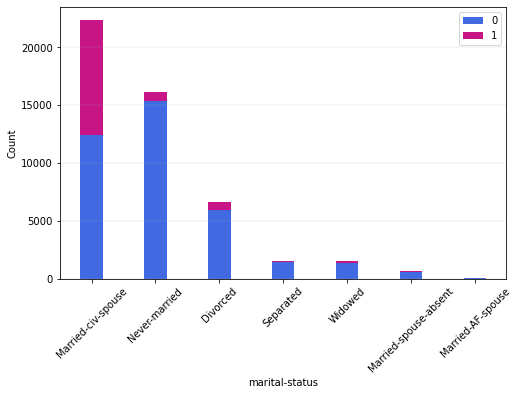

In [34]:
stacked_bar_chart(df, 'marital-status')

<div class="alert alert-block alert-success">
    <h4>
        education
    </h4>
</div>

The first 8 items have been plotted.


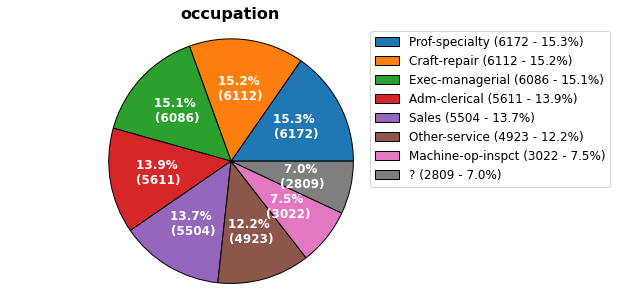

In [35]:
df_occu = percentCol(df, 'occupation')
pie_chart(df_occu, title='occupation')

The first 8 items have been plotted.
                      0     1
occupation                   
Prof-specialty     3388  2784
Craft-repair       4729  1383
Exec-managerial    3178  2908
Adm-clerical       4843   768
Sales              4029  1475
Other-service      4719   204
Machine-op-inspct  2650   372
?                  2544   265


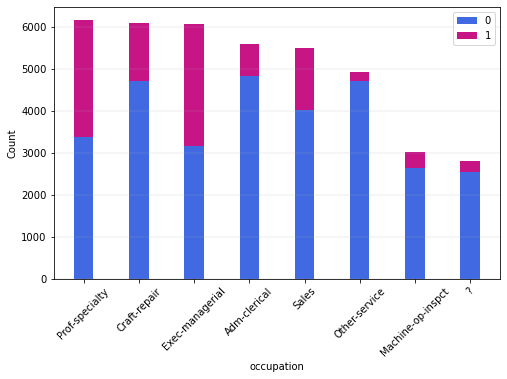

In [36]:
stacked_bar_chart(df, 'occupation')

<div class="alert alert-block alert-success">
    <h4>
        relationship
    </h4>
</div>

In [37]:
df.columns

['workclass',
 'fnlwgt',
 'education',
 'educational-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'label',
 'AgeGrb']

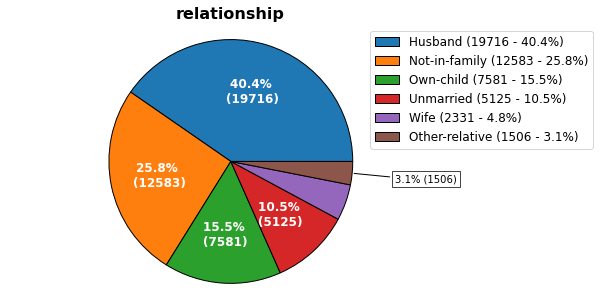

In [38]:
df_rel = percentCol(df, 'relationship')
pie_chart(df_rel, title='relationship')

                    0     1
relationship               
Husband         10870  8846
Not-in-family   11307  1276
Own-child        7470   111
Unmarried        4816   309
Wife             1238  1093
Other-relative   1454    52


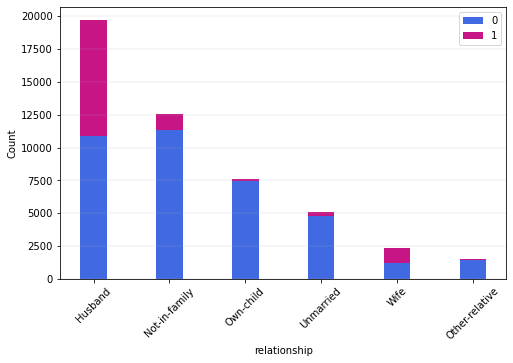

In [39]:
stacked_bar_chart(df, 'relationship')

<div class="alert alert-block alert-success">
    <h4>
        race
    </h4>
</div>

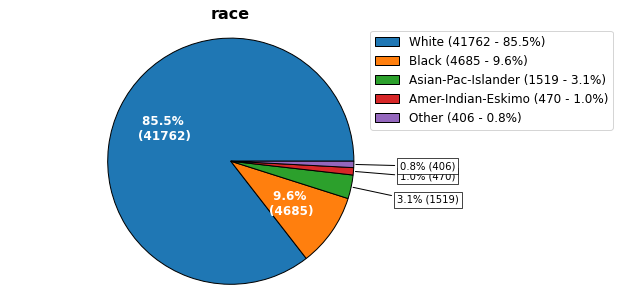

In [40]:
df_race = percentCol(df, 'race')
pie_chart(df_race, title='race')

                        0      1
race                            
White               31155  10607
Black                4119    566
Asian-Pac-Islander   1110    409
Amer-Indian-Eskimo    415     55
Other                 356     50


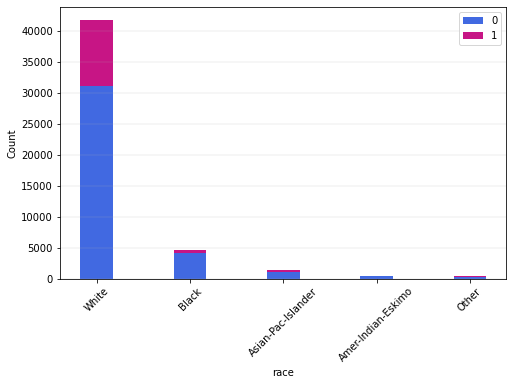

In [41]:
stacked_bar_chart(df, 'race')

<div class="alert alert-block alert-success">
    <h4>
        gender
    </h4>
</div>

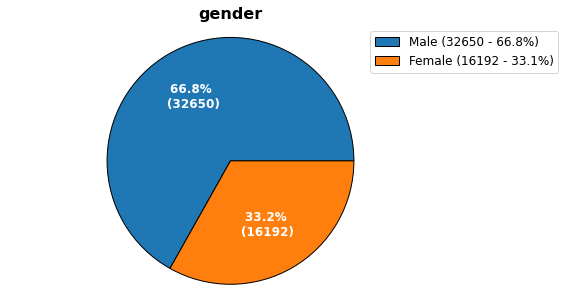

In [42]:
df_gender = percentCol(df, 'gender')
pie_chart(df_gender, title='gender')

            0     1
gender             
Male    22732  9918
Female  14423  1769


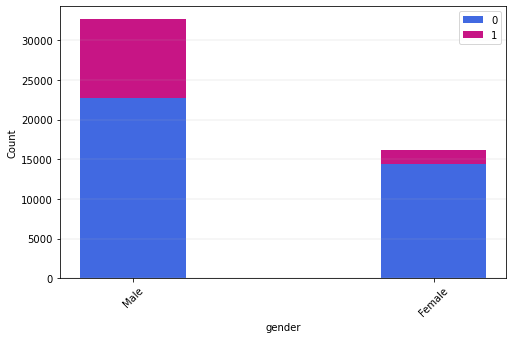

In [43]:
stacked_bar_chart(df, 'gender')

<div class="alert alert-block alert-success">
    <h4>
        capital-gain
    </h4>
</div>

The first 8 items have been plotted.


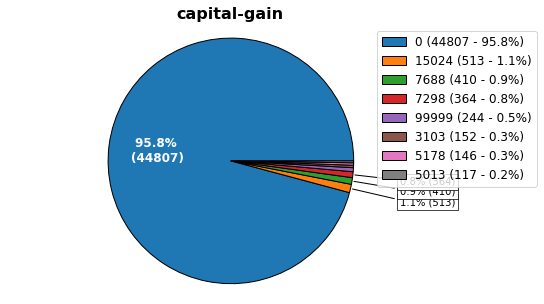

In [44]:
df_cap_gain = percentCol(df, 'capital-gain')
pie_chart(df_cap_gain, title='capital-gain')

The first 8 items have been plotted.
                  0     1
capital-gain             
0             35611  9196
15024             0   513
7688              0   410
7298              0   364
99999             0   244
3103             10   142
5178              0   146
5013            117     0


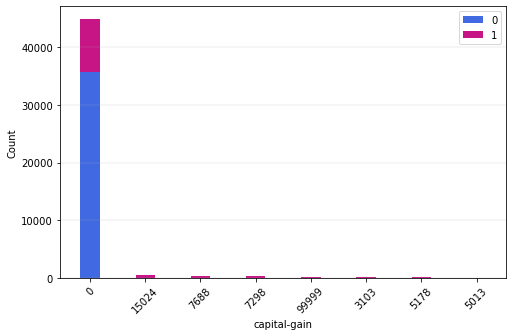

In [45]:
stacked_bar_chart(df, 'capital-gain')

<div class="alert alert-block alert-success">
    <h4>
        capital-loss
    </h4>
</div>

The first 8 items have been plotted.


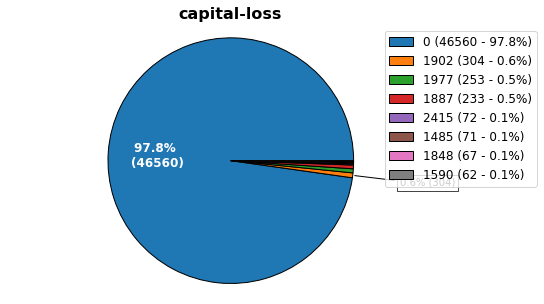

In [46]:
df_cap_loss = percentCol(df, 'capital-loss')
pie_chart(df_cap_loss, title='capital-loss')

The first 8 items have been plotted.
                  0      1
capital-loss              
0             36017  10543
1902             18    286
1977              0    253
1887              0    233
2415              0     72
1485             26     45
1848              0     67
1590             62      0


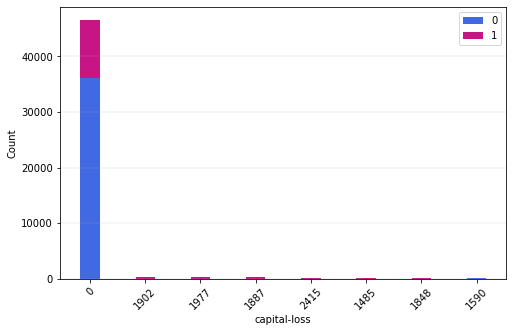

In [47]:
stacked_bar_chart(df, 'capital-loss')

<div class="alert alert-block alert-success">
    <h4>
        hours-per-week
    </h4>
</div>

The first 8 items have been plotted.


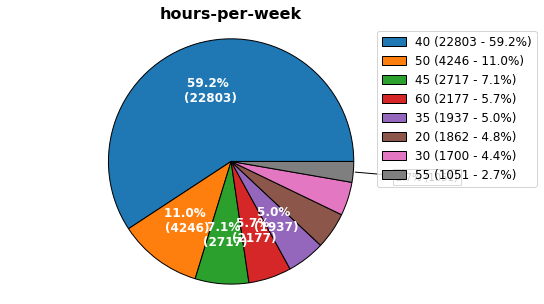

In [48]:
df_hpw = percentCol(df, 'hours-per-week')
pie_chart(df_hpw, title='hours-per-week')

The first 8 items have been plotted.
                    0     1
hours-per-week             
40              17953  4850
50               2345  1901
45               1710  1007
60               1223   954
35               1653   284
20               1750   112
30               1584   116
55                561   490


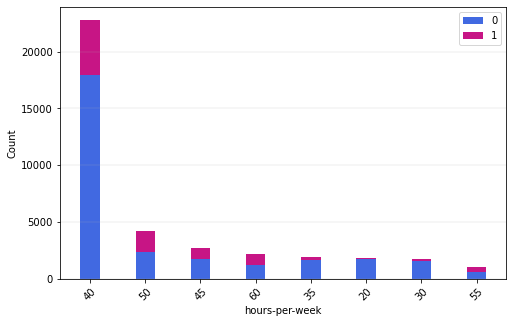

In [49]:
stacked_bar_chart(df, 'hours-per-week')

<div class="alert alert-block alert-success">
    <h4>
        native-country
    </h4>
</div>

The first 8 items have been plotted.


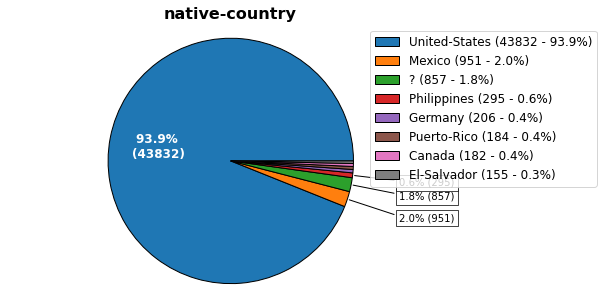

In [50]:
df_native = percentCol(df, 'native-country')
pie_chart(df_native, title='native-country')

The first 8 items have been plotted.
                    0      1
native-country              
United-States   33138  10694
Mexico            904     47
?                 637    220
Philippines       210     85
Germany           148     58
Puerto-Rico       164     20
Canada            119     63
El-Salvador       144     11


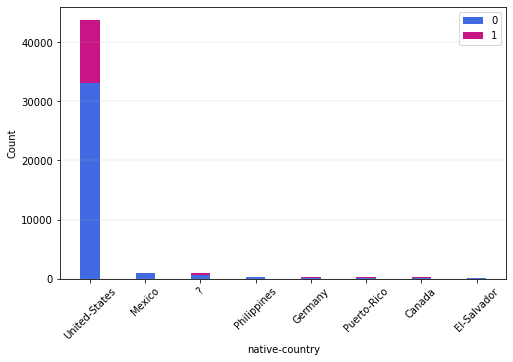

In [51]:
stacked_bar_chart(df, 'native-country')

<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        String Indexer
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Move the label column to end and encodes it
</div>

In [52]:
labelCol = ["label"]
cols = [i for i in df.columns if not i in labelCol]
new_order = cols + labelCol
df = df.select(new_order)

<div class="alert alert-block alert-warning">
        Get Categorical Features
</div>

In [53]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if not item[1].startswith('string')]
print(f"Categorical features:{cat_cols}")
print('='*50)
print(f"Numerical features:{num_cols}")

Categorical features:['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'AgeGrb']
Numerical features:['fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'label']


<div class="alert alert-block alert-warning">
        String Indexer
</div>

In [54]:
df_enc = stringIndexer(df, cat_cols, dropInput=True)
cols = [i for i in df_enc.columns if not i in labelCol]
new_order = cols + labelCol
df_enc = df_enc.select(new_order)

In [55]:
pd.DataFrame(df_enc.take(3), columns=df_enc.columns)

,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,AgeGrb,label
0,226802,7,0,0,40,0,5,1,6,2,1,0,0,1,0
1,89814,9,0,0,50,0,0,0,10,0,0,0,0,0,0
2,336951,12,0,0,40,2,6,0,12,0,0,0,0,1,1


<a id='5.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Vector Assembler
   </h3>
</div>

In [56]:
cols_for_vec = df_enc.columns
cols_for_vec.remove("label")
vec_assem = VectorAssembler(inputCols=cols_for_vec, outputCol="features")
vec_trans = vec_assem.transform(df_enc)
vec_trans = vec_trans.select("features", "label")

<a id='5.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature engineering
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Check categorical Features
    </h4>
</div>

In [57]:
cat_cols = [item[0] for item in df_enc.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df_enc.dtypes if not item[1].startswith('string')]
print(f"Categorical features:{cat_cols}")
print('='*50)
print(f"Numerical features:{num_cols}")

Categorical features:[]
Numerical features:['fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'AgeGrb', 'label']


- There is no categorical columns in the dataframe

<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value 

In [58]:
from pyspark.ml.feature import VarianceThresholdSelector
fvts = VarianceThresholdSelector(varianceThreshold=0.01, featuresCol="features", outputCol="selectedFeatures")
fvts_model = fvts.fit(vec_trans)
vec_trans = fvts_model.transform(vec_trans).drop("features")\
.withColumnRenamed("selectedFeatures", "features").select("features", "label")

22/01/22 00:16:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [59]:
fvts_model.selectedFeatures

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [60]:
print(cols_for_vec)

['fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'AgeGrb']


<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" style="height:250px">

Pearson correlation coefficient
- a measure of linear correlation between features
- the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation
- the result always has a value between −1 and 1

In [61]:
from pyspark.ml.stat import Correlation

def highly_correlated_features(df, threshold):
    # correlation will be in Dense Matrix
    matrix = Correlation.corr(df, 'features')
    corr_matrix = pd.DataFrame(matrix.collect()[0][matrix.columns[0]].toArray(), 
                               columns=cols_for_vec, index=cols_for_vec)

    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if absF(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = absF(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(vec_trans.select("features"), 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

Traceback (most recent call last):                                              
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
22/01/22 00:16:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/22 00:16:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,Feature_1,Feature_2,Corr_value


<div class="alert alert-block alert-warning">
        Feature importance based on RandomForestClassifier
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [62]:
from pyspark.ml.classification import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list
        
        df_for_vec = df_enc.select(correlated_features_list + ["label"])
        df_vec = vectorAssembler(df_for_vec, correlated_features_list, "label")

        rf=RandomForestClassifier(labelCol="label")
        rf_trained = rf.fit(df_vec)
        feature_imp_array = rf_trained.featureImportances.toArray()
    
        feat_imp_list = []
        for feature, importance in zip(correlated_features_list, feature_imp_array):
            feat_imp_list.append((feature, importance))
        df_feat_imp = pd.DataFrame(feat_imp_list)
        df_feat_imp.columns = ['Feature', 'Importance']
        df_feat_imp.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_feat_imp['Feature'][1:].values)
    
print(dropped_feature_list)  

[]


In [ ]:
# df_enc = df_enc.drop(dropped_feature_list)

<a id='5.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

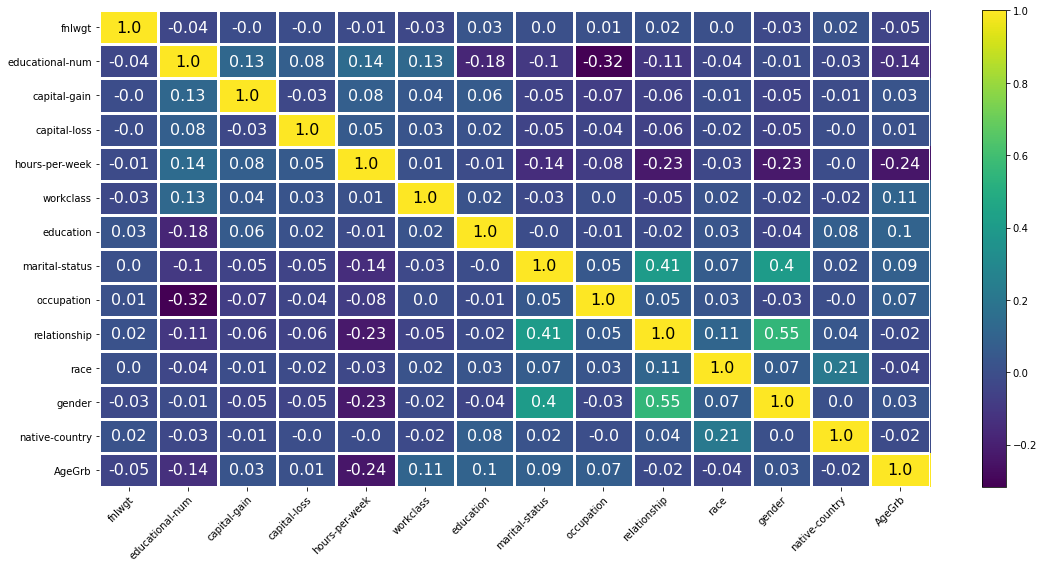

In [63]:
from pyspark.ml.stat import Correlation

# correlation will be in Dense Matrix
matrix = Correlation.corr(vec_trans, 'features').collect()[0][0]

# convert Dense Matrix into DataFrame
corr_mat = matrix.toArray().tolist()
create_heatmap(corr_mat, cols_for_vec, figsize=(16, 8))

<div class="alert alert-block alert-warning">
        ["fnlwgt"] have no correlation with other columns
</div>

In [64]:
df_enc = df_enc.drop("fnlwgt")

In [65]:
pd.DataFrame(df_enc.take(3), columns=df_enc.columns)

Traceback (most recent call last):
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,AgeGrb,label
0,7,0,0,40,0,5,1,6,2,1,0,0,1,0
1,9,0,0,50,0,0,0,10,0,0,0,0,0,0
2,12,0,0,40,2,6,0,12,0,0,0,0,1,1


<a id='5.5'></a>
<div class="alert alert-block alert-info">
   <h3>
        Over-sampling using SMOTE
   </h3>
</div>

In [66]:
df_0_forSmote = df_enc.where(col("label") == 0)
df_1_forSmote = df_enc.where(col("label") == 1)

In [67]:
# take 70% of the class_0 and concat it with class_1
df_forSmote = df_0_forSmote.sample(fraction=0.7, seed=1).union(df_1_forSmote).toPandas()

In [68]:
# Class count
count_class_0, count_class_1 = df_forSmote['label'].value_counts()
print(count_class_0, count_class_1)

26080 11687


In [69]:
# over sampling
from imblearn.over_sampling import SMOTE

X = df_forSmote.drop('label', axis=1)
y = df_forSmote['label']

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [70]:
y_sm.value_counts()

0    26080
1    26080
Name: label, dtype: int64

In [71]:
df_smoted = pd.concat([X_sm, y_sm], axis=1)

In [72]:
# Create PySpark DataFrame from Pandas
df_smoted_1=spark.createDataFrame(df_smoted[df_smoted["label"] == 1]) 

In [73]:
# concat class_1_smoted with class_0_before_smoted
df_enc_smoted = df_0_forSmote.union(df_smoted_1)

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

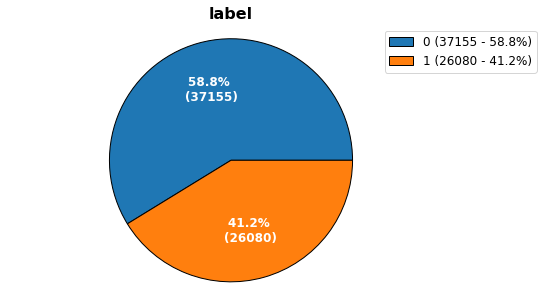

In [74]:
df_label_smoted = percentCol(df_enc_smoted, 'label')
pie_chart(df_label_smoted, title='label')

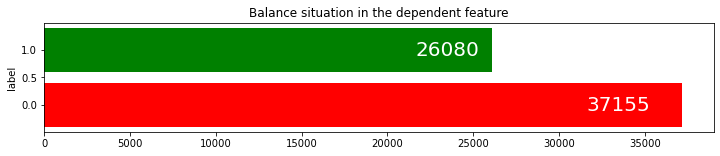

In [75]:
# The difference between >50K and <=50K values in the dependent feature is almost same. 
# So the dataset is in balance.
uniqs = [i for i in df_label_smoted.index]
vals = [i for i in df_label_smoted["count"].values]

fig, ax = plt.subplots(figsize = (12, 2))
# Horizontal bar chart
ax.barh(uniqs, vals, align='center', color=['red', 'green'])
ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
ax.text(vals[1]-vals[1]*0.1, 1, vals[1], ha='center', va='center', color='w', size=20)
ax.set_ylabel("label")
ax.set_title('Balance situation in the dependent feature')

plt.show()

<div class="alert alert-block alert-warning">
        Vector Assembler
</div>

In [76]:
# cols_for_vec = df_enc_smoted.columns
# cols_for_vec.remove("label")
# vec_assem = VectorAssembler(inputCols=cols_for_vec, outputCol="features")
# vec_trans = vec_assem.transform(df_enc_smoted)
# vec_trans = vec_trans.select("features", "label")

<a id='5.6'></a>
<div class="alert alert-block alert-info">
   <h3>
        Normalization
   </h3>
</div>

In [77]:
df_enc_smoted = df_enc_smoted.withColumn("cap_gain_scaled", df_enc_smoted["capital-gain"] / 
                                         df_enc_smoted.select(sum("capital-gain")).first()[0])\
.drop("capital-gain").withColumnRenamed("cap_gain_scaled", "capital-gain")

In [78]:
df_enc_smoted = df_enc_smoted.withColumn("cap_loss_scaled", df_enc_smoted["capital-loss"] / 
                                         df_enc_smoted.select(sum("capital-loss")).first()[0])\
.drop("capital-loss").withColumnRenamed("cap_loss_scaled", "capital-loss")

<div class="alert alert-block alert-warning">
        Move the label column to end and encodes it
</div>

In [79]:
cols = [i for i in df_enc_smoted.columns if i!="label"]
new_order = cols + ["label"]
df_enc_smoted = df_enc_smoted.select(new_order)

<div class="alert alert-block alert-warning">
        Vector Assembler
</div>

In [80]:
cols_for_vec = df_enc_smoted.columns
cols_for_vec.remove("label")
vec_assem = VectorAssembler(inputCols=cols_for_vec, outputCol="features")
vec_trans = vec_assem.transform(df_enc_smoted)
vec_trans = vec_trans.select("features", "label")

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [81]:
cat_cols = ['educational-num', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 
            'relationship', 'race', 'gender', 'native-country', 'AgeGrb']
df_ohe = oneHotEncoder(df_enc_smoted, cat_cols, stringIndexer=False)

<div class="alert alert-block alert-warning">
        Move the label column to end and encodes it
</div>

In [82]:
cols = [i for i in df_ohe.columns if i!="label"]
new_order = cols + ["label"]
df_ohe = df_ohe.select(new_order)

In [83]:
pd.DataFrame(df_ohe.take(3), columns=df_ohe.columns)

,capital-gain,capital-loss,educational-num_ohe,hours-per-week_ohe,workclass_ohe,education_ohe,marital-status_ohe,occupation_ohe,relationship_ohe,race_ohe,gender_ohe,native-country_ohe,AgeGrb_ohe,label
0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",0
1,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0
2,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)",0


<a id='5.7'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

In [84]:
df_ohe_for_vec = df_ohe.drop("deposit").withColumnRenamed("deposit_si", "label")
inputCols = [i for i in df_ohe_for_vec.columns if i!="label"]
# labelCol = "deposit"
df_vec = vectorAssembler(df_ohe_for_vec, inputCols, "label")
df_train, df_test = df_vec.randomSplit([0.60,0.40])

<div class="alert alert-block alert-success">
    <h4>
        Logistic Regression
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [85]:
# %%time
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# lr = LogisticRegression(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(lr.threshold,[0.40, 0.45,0.50,0.55, 0.60])\
# #              .addGrid(lr.maxIter, [8,9,10,11,12])\
#              .addGrid(lr.family, ["auto", "binomial", "multinomial"])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train)

In [86]:
# crossvalidateData.bestModel.extractParamMap()

In [87]:
# crossvalidateData.bestModel.getOrDefault("threshold")
# crossvalidateData.bestModel.getOrDefault("maxIter")
# crossvalidateData.bestModel.getOrDefault("family")
# # best_params : threshold=0.5, maxIter=11, family="multinomial"

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

22/01/22 00:17:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/01/22 00:17:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 474 ms, sys: 142 ms, total: 616 ms
Wall time: 36.3 s


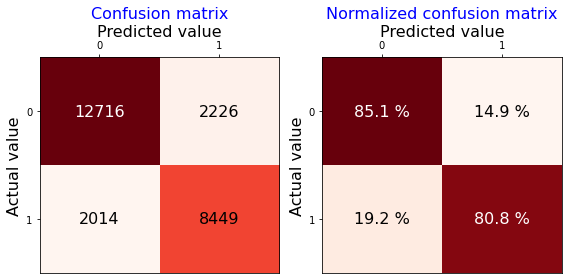

In [88]:
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(lr.threshold,[0.5])\
             .addGrid(lr.maxIter, [11])\
             .addGrid(lr.family, ["multinomial"])\
             .build()
)
log_cm_metrics, log_pred = BuildMLModel(lr, df_train, df_test, paramGrid)

In [89]:
# log_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Decision Tree Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [90]:
# %%time
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(dt.maxDepth,[9,10,11,12])\
# #              .addGrid(dt.maxBins,[15,20,25])\
#              .addGrid(dt.impurity, ["entropy", "gini"])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train)

In [91]:
# crossvalidateData.bestModel.extractParamMap()

In [92]:
# crossvalidateData.bestModel.getOrDefault("maxDepth")
# crossvalidateData.bestModel.getOrDefault("maxBins")
# crossvalidateData.bestModel.getOrDefault("impurity")
# # best_params : maxDepth=9, maxBins=25, impurity="gini"

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 636 ms, sys: 218 ms, total: 854 ms
Wall time: 35.5 s


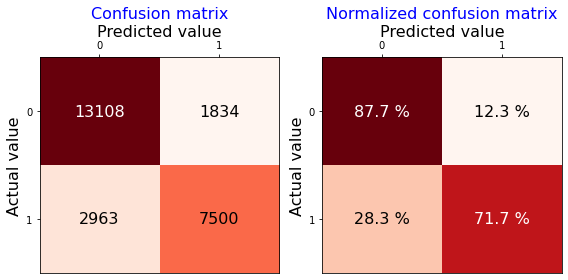

In [93]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(dt.maxDepth,[9])\
             .addGrid(dt.maxBins,[25])\
             .addGrid(dt.impurity, ["gini"])\
             .build()
)
dt_cm_metrics, dt_pred = BuildMLModel(dt, df_train, df_test, paramGrid)

In [94]:
# dt_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Random Forest Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

In [95]:
# %%time
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# rf = RandomForestClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(rf.maxDepth,[7,8,9])\
# #              .addGrid(rf.maxBins,[25,30,35,40])\
# #              .addGrid(rf.impurity, ["entropy", "gini"])\
#              .addGrid(rf.numTrees, [100,110,120,130,140,150])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train)

In [96]:
# crossvalidateData.bestModel.extractParamMap()

In [97]:
# crossvalidateData.bestModel.getOrDefault("maxDepth")
# crossvalidateData.bestModel.getOrDefault("maxBins")
# crossvalidateData.bestModel.getOrDefault("impurity")
# crossvalidateData.bestModel.getOrDefault("numTrees")
# # best_params : maxDepth=9, maxBins=25, impurity="gini", numTrees=130

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

22/01/22 00:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1371.8 KiB
22/01/22 00:18:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/01/22 00:18:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/01/22 00:18:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/01/22 00:18:37 WARN DAGScheduler: Broadcasting large task binary with size 1381.3 KiB
22/01/22 00:18:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/01/22 00:18:40 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/01/22 00:18:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/01/22 00:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1368.1 KiB
22/01/22 00:18:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/01/22 00:18:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/01/22 00:18:55 WARN DAGScheduler: Broadcas

CPU times: user 704 ms, sys: 262 ms, total: 966 ms
Wall time: 1min 21s


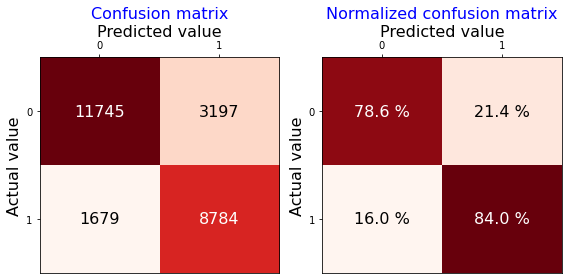

In [98]:
%%time
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(rf.maxDepth,[8])\
             .addGrid(rf.maxBins,[25])\
             .addGrid(rf.impurity, ["gini"])\
             .addGrid(rf.numTrees, [130])\
             .build()
)
rf_cm_metrics, rf_pred = BuildMLModel(rf, df_train, df_test, paramGrid)

In [99]:
rf_cm_metrics

,True Positive Rate,True Negative Rate,Accuracy,Balanced Accuracy,Precision,Negative Predictive Value,False Discovery Rate,False Omission Rate,Prevalence Threshold,F1 Score,Matthews Correlation Coefficient,False positive rate,False Negative Rate
,0.84,0.79,0.81,0.82,0.73,0.87,0.27,0.13,0.33,0.78,0.62,0.21,0.16


<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [100]:
# %%time

# from pyspark.ml.classification import NaiveBayes
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# nb = NaiveBayes(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(nb.modelType,["multinomial", "gaussian"])\
#              .addGrid(nb.smoothing,[0.0, 0.002,0.004,0.006])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
# crossvalidateData=crossvalidation.fit(df_train)

In [101]:
# crossvalidateData.bestModel.extractParamMap()

In [102]:
# crossvalidateData.bestModel.getOrDefault("modelType")
# crossvalidateData.bestModel.getOrDefault("smoothing")
# # best_params : modelType="multinomial", smoothing=0.002

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 545 ms, sys: 178 ms, total: 723 ms
Wall time: 20.9 s


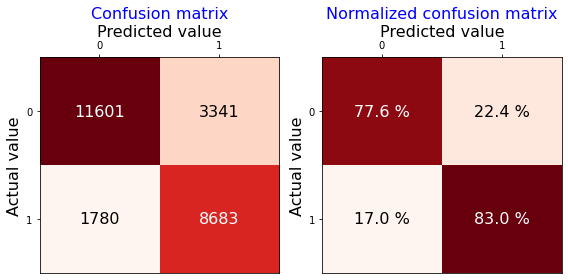

In [103]:
%%time
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
nb = NaiveBayes(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(nb.modelType,["multinomial"])\
             .addGrid(nb.smoothing,[0.002])\
             .build()
)
nb_cm_metrics, nb_pred = BuildMLModel(nb, df_train, df_test, paramGrid)

<div class="alert alert-block alert-success">
    <h4>
        Gradient-Boosted Tree Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

In [104]:
# %%time
# from pyspark.ml.classification import GBTClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# gbt = GBTClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(gbt.featureSubsetStrategy, ["auto", "all", "sqrt", "onethird", "log2"])\
# #              .addGrid(gbt.maxBins, [110,120,130])\
# #              .addGrid(gbt.maxDepth, [1,3,5,8])\
# #              .addGrid(gbt.maxIter, [55,60,65])\
#              .addGrid(gbt.stepSize,[0.39, 0.392, 0.394, 0.396, 0.398, 0.399])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train)

In [105]:
# crossvalidateData.bestModel.extractParamMap()

In [106]:
# crossvalidateData.bestModel.getOrDefault("featureSubsetStrategy")
# crossvalidateData.bestModel.getOrDefault("maxBins")
# crossvalidateData.bestModel.getOrDefault("maxDepth")
# crossvalidateData.bestModel.getOrDefault("maxIter")
# crossvalidateData.bestModel.getOrDefault("stepSize")

# # best_params : featureSubsetStrategy="auto", maxBins=110, maxDepth=8, maxIter=60, stepSize=0.392, 

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 624 ms, sys: 227 ms, total: 851 ms
Wall time: 30 s


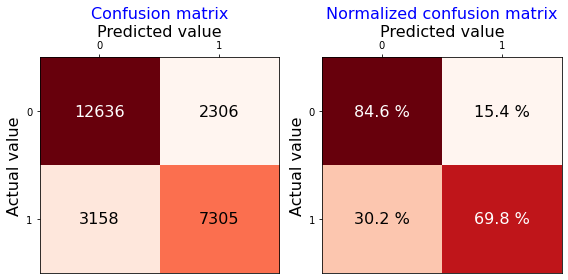

In [107]:
%%time
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
gbt = GBTClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(gbt.featureSubsetStrategy, ["auto"])\
             .addGrid(gbt.maxBins, [110])\
             .addGrid(gbt.maxDepth, [8])\
             .addGrid(gbt.maxIter, [60])\
             .addGrid(gbt.stepSize,[0.392])\
             .build()
)
gbt_cm_metrics, gbt_pred = BuildMLModel(rf, df_train, df_test, paramGrid)

In [108]:
# gbt_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Linear Support Vector Machine
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [109]:
# %%time
# from pyspark.ml.classification import LinearSVC
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# lsc = LinearSVC(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(lsc.aggregationDepth,[2,3,4,5,6])\
# #              .addGrid(lsc.maxIter, [35,40,45,50])\
#              .addGrid(lsc.threshold, [0.126,0.127,0.128,0.129])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=lsc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
# crossvalidateData=crossvalidation.fit(df_train)

In [110]:
# crossvalidateData.bestModel.extractParamMap()

In [111]:
# crossvalidateData.bestModel.getOrDefault("aggregationDepth")
# crossvalidateData.bestModel.getOrDefault("maxIter")
# crossvalidateData.bestModel.getOrDefault("threshold")
# # best_params : aggregationDepth=2, maxIter=45,, threshold=0.126

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 906 ms, sys: 345 ms, total: 1.25 s
Wall time: 57.8 s


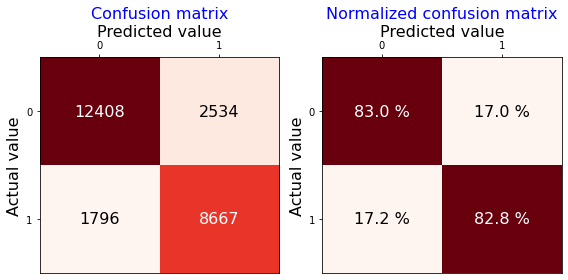

In [112]:
%%time
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lsc = LinearSVC(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(lsc.aggregationDepth,[2])\
             .addGrid(lsc.maxIter, [45])\
             .addGrid(lsc.threshold, [0.126])\
             .build()
)
lsv_cm_metrics, lsv_pred = BuildMLModel(lsc, df_train, df_test, paramGrid, modelName="LinearSVC")

<a id='5.8'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [113]:
log_metrics = log_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
dt_metrics = dt_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
rf_metrics = rf_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
nb_metrics = nb_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
gbt_metrics = gbt_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
lsv_metrics = lsv_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
df_models = pd.concat([log_metrics, dt_metrics, rf_metrics, nb_metrics, gbt_metrics, lsv_metrics], axis=0)
df_models.index = ["log", "dt", "rf", "nb", "gbt", "lsv"]
df_models = df_models.sort_values("Accuracy", ascending=False)
df_models

,Accuracy,True Negative Rate,True Positive Rate
log,0.83,0.85,0.81
lsv,0.83,0.83,0.83
dt,0.81,0.88,0.72
rf,0.81,0.79,0.84
nb,0.80,0.78,0.83
gbt,0.78,0.85,0.70


<a id='5.9'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Logistic Regression selected
</div>

In [114]:
model_pred = log_pred

In [115]:
y_train_prob = np.array([i[0][1] for i in model_pred.select("probability").collect()])
y_train = np.array([i[0] for i in model_pred.select("label").collect()])

In [116]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_train_pred = (y_train_prob >= i/1000).astype('int')
    cm_train = confusion_matrix(y_train, y_train_pred)
    TN, FP, FN, TP = cm_train.ravel()
    
    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_train = roundF(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR_train = roundF(TN / (TN + FP), 2)
    # False positive rate or False alarm rate
    FPR_train = roundF(FP / (FP + TN), 2)
    # accuracy (ACC)
    acc_train = roundF((TP + TN) / (TP + TN + FP + FN), 2)
    # Precision or positive predictive value
    precision_train = roundF(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    npv_train = roundF(TN / (TN + FN), 2)    

    
#     df_cm_train_metrics = TP_FP_TN_FN_func(cm_train, 'Test')
#     TPR_train = df_cm_train_metrics.loc['True Positive Rate',0]
#     TNR_train = df_cm_train_metrics.loc['True Negative Rate',0]
#     FPR_train = df_cm_train_metrics.loc['False positive rate',0]
#     acc_train = df_cm_train_metrics.loc['Accuracy',0]
#     precision_train = df_cm_train_metrics.loc['Precision',0]
#     npv_train = df_cm_train_metrics.loc['Negative Predictive Value',0]
    
    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/1000)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 8.16 s, sys: 42.6 ms, total: 8.2 s
Wall time: 8.22 s


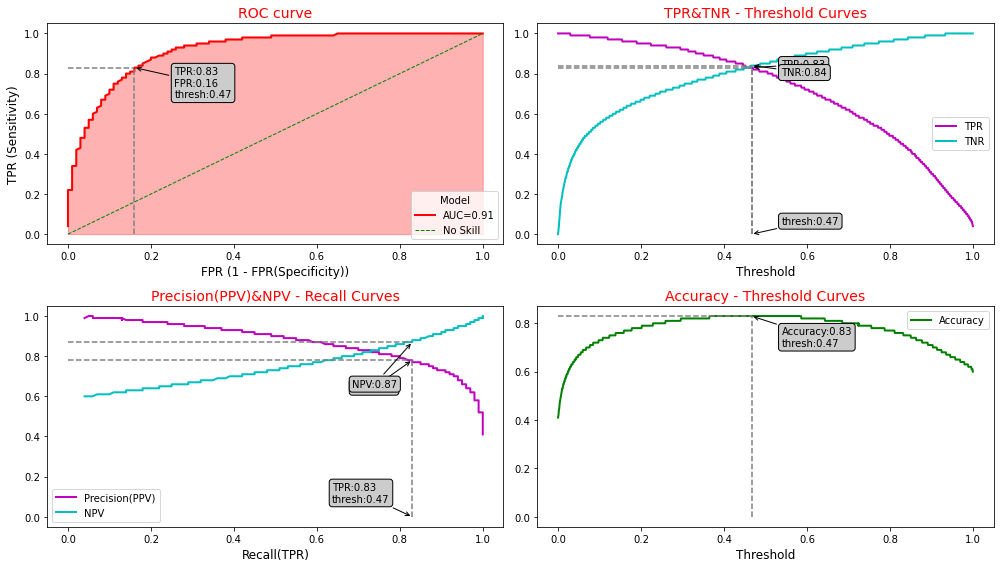

In [117]:
from sklearn.metrics import roc_auc_score

threshold=0.465
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_train, y_train_prob)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-warning">
        Final Confusion Matrix with new Threshold
</div>

In [118]:
y_train_pred = (y_train_prob  >= threshold).astype('int')
cm_final = confusion_matrix(y_train, y_train_pred)
cm_final_norm = confusion_matrix(y_train, y_train_pred, normalize='true')

,True Positive Rate,True Negative Rate,Accuracy,Balanced Accuracy,Precision,Negative Predictive Value,False Discovery Rate,False Omission Rate,Prevalence Threshold,F1 Score,Matthews Correlation Coefficient,False positive rate,False Negative Rate
,0.83,0.84,0.83,0.84,0.78,0.87,0.22,0.13,0.31,0.8,0.66,0.16,0.17


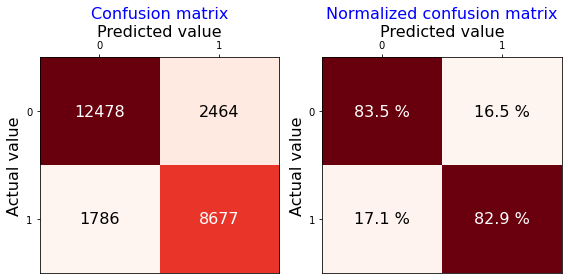

In [119]:
confusion_matrix_func(cm_final, cm_final_norm)

In [120]:
#Close spark session
spark.stop()